# Study architectures for NLP - Disaster tweets dataset

Kaggle: https://www.kaggle.com/c/nlp-getting-started

In [1]:
!pip install tensorflow_hub --quiet
!pip install chakin --quiet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import time
import os
import chakin

### tf2.x
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
# Global random state
np.random.seed(42)
tf.random.set_seed(42)

# Pandas
pd.set_option('max_colwidth', 280)  # display the whole tweet

# Some common variables
os.chdir('/root/Keras RNN - disaster tweets')
PATH_CHECKPOINT = './checkpoints'
root_logdir ='s3://tensor.board/disaster_tweets/logs'

In [4]:
# Custom functions
def reset_keras():
    keras.backend.clear_session()
    
def get_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Get the dataset

In [5]:
df_train_raw = pd.read_csv('./train.csv')
df_test_raw = pd.read_csv('./test.csv')

print(df_train_raw.shape, df_test_raw.shape)

(7613, 5) (3263, 4)


In [6]:
# Make a copy to avoid modifying the original dataset
df = df_train_raw[['text', 'target']].copy()  # Make use of only the text field for NLP experiment

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


# EDA & data processing

<hr>

The Disaster Tweets dataset contains 7613 records (i.e., tweets) in the training set and 3623 in the test set. As the dataset is not big, we will achieve much better performance by relying on pretrained model and/or word vectors. There is a slight class imbalance (0: 57.4%, 1: 42.6%), which does not need to be fixed. Moreoever, the dataset requires minimal preprocessing:

* Deduplicate records (same text and same target)
* Drop contradictive records (same text but opposite target)

Below is a list of text processing which we have decided not to perform, as we have tested the methods do not have much impact to the model performance.

* Stop word removal
* URL replacement

<hr>

In [7]:
df.describe(include='all')

,text,target
count,7613,7613.00000
unique,7503,NaN
top,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,10,NaN
mean,NaN,0.42966
std,NaN,0.49506
min,NaN,0.00000
25%,NaN,0.00000
50%,NaN,0.00000
75%,NaN,1.00000


In [8]:
# Looks like there are some duplication
df.duplicated().sum()

92

In [9]:
# Deduplicate the dataset
df.drop_duplicates(inplace=True)

In [10]:
# There are still records with the exact same text but different target. Remove all of them
df.drop_duplicates(subset='text', keep=False, inplace=True)

In [11]:
# Check NA
df.isna().sum()

text      0
target    0
dtype: int64

In [12]:
# Check class imbalance
df['target'].value_counts(normalize=True)

0    0.574081
1    0.425919
Name: target, dtype: float64

In [13]:
# Look at a few postive classes
df[df['target'] == 1][:5]

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [14]:
# Look at a few negative classes
df[df['target'] == 0][-5:]

,text,target
7581,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO,0
7582,Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4,0
7584,These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittensÛ_ https://t.co/TFGrAyuDC5,0
7587,Sirens everywhere!,0
7593,I just heard a really loud bang and everyone is asleep great,0


In [15]:
# Split the training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df['text'].values,
                                                      df['target'].values,
                                                      test_size=.2,
                                                      random_state=42)

# Research design

<hr>

We first make use of a pretrained sentence encoder from TensorFlow Hub. nnlm-en-dim50 is pretrained sentence encoder based on NNLM architecture, trained on English Google News 7B corpus, which takes input of a sentence (1-D tensor of strings) and output 50 dimensions. With this we do not need to perform any text tokenization, and the output of the layer (encoded sentence) can be fed directly to dense layers for classification. This is the baseline of our experiments, with least effort of text preprocessing.

Next we utilize a couple of pretrained word vectors, trained with GloVe on a) Wikipedia pages and Gigaword - 6B tokens, 400 vocab, and b) twitter messages - 27B tokens, 1.2M vocab. This method takes significantly more effort to preprocess, including text tokenization, padding, and looking up from the pretrained vector to form the embedding matrix. The output of the embedding layer is in a shape of (batch size, time step, embedding dimension) and we will feed to GRU layers followed by a dense output layer for classification.

Tokenize: Remove specified punctuations, and split the words by space. Each sentence (sequence of tokens) is then converted into a sequence of integers (index of the token in the generated dictionary).

Padding: The integer 0 (unused during tokenization) is padded towards the end of the sentence, making all records (tweets) have the same length (40 sequences)

Preparing the embedding matrix: The pretrained word vector contains a dict of vocab, each represented as a 200-dimension vector. All identified tokens in the training data set (20108) will be mapped into a matrix, with an additional row representing all-zero (e.g., unseen tokens in the training set, unseen vocab in the pretrained word vector, padding, etc.)

<hr>

## nnlm-en-dim50

In [42]:
reset_keras()

# Build the model
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",
                   dtype=tf.string, input_shape=[], trainable=True),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 48,197,257
Trainable params: 48,197,257
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [18]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/nnlm-en-dim50.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/disaster_tweets/logs/run_2020_05_29-06_05_24


In [19]:
%%time

# Fit the model
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb],
    shuffle=True
    )

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 13s 2ms/sample - loss: 0.6785 - accuracy: 0.5850 - val_loss: 0.6444 - val_accuracy: 0.7061
Epoch 2/100
5988/5988 [==============================] - 12s 2ms/sample - loss: 0.6129 - accuracy: 0.7420 - val_loss: 0.5900 - val_accuracy: 0.7482
Epoch 3/100
5988/5988 [==============================] - 12s 2ms/sample - loss: 0.5564 - accuracy: 0.7712 - val_loss: 0.5455 - val_accuracy: 0.7715
Epoch 4/100
5988/5988 [==============================] - 12s 2ms/sample - loss: 0.5033 - accuracy: 0.7907 - val_loss: 0.5110 - val_accuracy: 0.7782
Epoch 5/100
5988/5988 [==============================] - 12s 2ms/sample - loss: 0.4562 - accuracy: 0.8064 - val_loss: 0.4875 - val_accuracy: 0.7829
Epoch 6/100
5988/5988 [==============================] - 12s 2ms/sample - loss: 0.4156 - accuracy: 0.8246 - val_loss: 0.4734 - val_accuracy: 0.7869
Epoch 7/100
5988/5988 [==============================] - 12s 2ms

### Evaluate

In [44]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/nnlm-en-dim50.h5')

In [45]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.80363   0.86156   0.83158       874
           1    0.78393   0.70465   0.74218       623

    accuracy                        0.79626      1497
   macro avg    0.79378   0.78311   0.78688      1497
weighted avg    0.79543   0.79626   0.79438      1497



In [46]:
# AUC score
roc_auc_score(y_valid, y_pred)

0.7831054798696789

### Predict

In [22]:
# Predict the classes
y_test = model.predict_classes(df_test_raw['text'].values)

# Prepare file for submission
submission = pd.DataFrame({'id': df_test_raw['id'].values,
                           'target': y_test[:,0]})
submission.to_csv('submission_nnlm-en-dim50.csv', index=False)

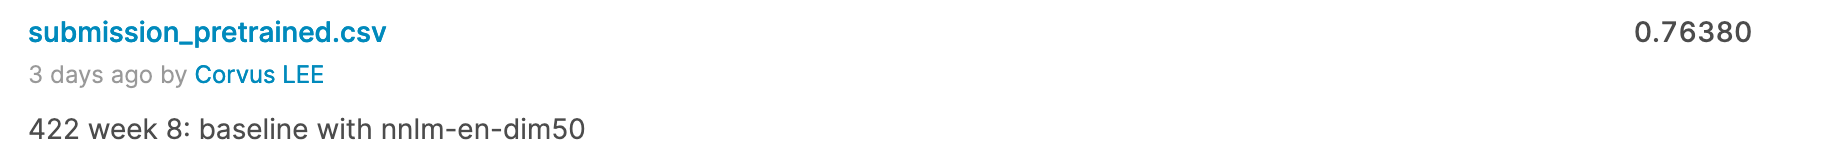

## GloVe.6B.200d

In [3]:
# List of pretrained word vectors
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [1]:
# Download the pretrained word vector
# chakin.download(number=13)

### Text processing

In [16]:
# Tokenize
tokenizer = Tokenizer()  # Default split as the pretrained word vector has http but not http://

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print('Number of unique tokens:', len(word_index))

Number of unique tokens: 19416


In [17]:
# Top 30 frequent tokens
list(word_index)[:30]

['t',
 'co',
 'http',
 'the',
 'a',
 'in',
 'to',
 'of',
 'i',
 'and',
 'is',
 'for',
 'on',
 'you',
 'my',
 'it',
 'that',
 'with',
 'at',
 'by',
 'this',
 'https',
 'are',
 'have',
 'from',
 'be',
 'was',
 'me',
 'like',
 'as']

In [18]:
# Padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

X_train_seq = pad_sequences(X_train_seq, padding='post', truncating='post', maxlen=40) 
X_valid_seq = pad_sequences(X_valid_seq, padding='post', truncating='post', maxlen=40)

print(X_train_seq.shape, X_valid_seq.shape)

(5988, 40) (1497, 40)


In [19]:
# How does the sequence (and padding) look like?
print(X_train[:1])
print(X_train_seq[:1])

['Arsonists being blamed for a blaze at a plastics recycling business in Adelaide | @pcaldicott7 reports. #7NewsAdl http://t.co/r1Xwdnvb0g']
[[5869  148 2392   12    5  655   19    5 5870 3003  691    6 5871 5872
   901 5873    3    1    2 5874    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [20]:
# Indexing word vectors
embeddings_index = {}

with open('glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        
print('Number of texts:', len(embeddings_index))

Number of texts: 400000


In [21]:
# How does the word 'twitter' look like in the embedding layer
embeddings_index['twitter']

array([-0.1253  ,  0.10986 , -0.24648 , -0.97699 ,  0.45639 , -0.19477 ,
       -0.57033 ,  0.21562 , -0.072833,  1.0522  , -1.2665  ,  1.0462  ,
        0.26052 ,  0.21486 , -0.25116 ,  0.47128 , -0.098183,  0.93993 ,
       -0.26196 ,  0.3106  , -1.4063  ,  0.69799 , -0.49484 ,  0.17524 ,
        0.10807 ,  0.54561 ,  0.028606,  0.1627  , -0.37475 ,  0.18744 ,
       -0.39069 , -0.010332,  0.074559,  0.67472 ,  0.64387 , -0.43194 ,
       -0.62811 , -0.2224  , -0.22347 ,  0.39007 , -0.65453 ,  0.21626 ,
        0.57612 , -0.085979, -0.2468  , -0.28975 , -0.24276 , -0.69023 ,
       -0.51486 ,  0.38971 , -0.60703 , -0.40067 ,  0.29745 ,  0.76046 ,
        0.3589  ,  0.78579 , -0.60273 ,  0.062597, -0.12338 ,  0.057467,
       -0.46938 , -0.22113 , -0.23502 ,  0.29893 ,  0.41463 , -0.08029 ,
        0.22822 ,  0.44344 ,  0.55317 ,  0.18224 , -0.3015  ,  0.16256 ,
        0.041161, -0.87026 , -0.61575 ,  0.14694 , -0.50751 , -0.45802 ,
        0.25354 ,  0.12844 ,  0.70521 ,  0.66433 , 

In [22]:
# Embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(19417, 200)

### Modeling

In [23]:
reset_keras()

# Build the model
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim,
                           embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                           input_length=40,
                           trainable=False),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           3883400   
_________________________________________________________________
gru (GRU)                    (None, 40, 128)           126720    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,109,321
Trainable params: 225,921
Non-trainable params: 3,883,400
_________________________________________________________________


In [24]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [25]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/glove.6B.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/disaster_tweets/logs/run_2020_05_31-02_30_52


In [26]:
%%time

# Fit the model
history = model.fit(
    x=X_train_seq,
    y=y_train,
    epochs=100,
    validation_data=(X_valid_seq, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb],
    shuffle=True
    )

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 8s 1ms/sample - loss: 0.6833 - accuracy: 0.5716 - val_loss: 0.6641 - val_accuracy: 0.5832
Epoch 2/100
5988/5988 [==============================] - 4s 707us/sample - loss: 0.5590 - accuracy: 0.7153 - val_loss: 0.4769 - val_accuracy: 0.7882
Epoch 3/100
5988/5988 [==============================] - 4s 705us/sample - loss: 0.4432 - accuracy: 0.8078 - val_loss: 0.4569 - val_accuracy: 0.7969
Epoch 4/100
5988/5988 [==============================] - 4s 719us/sample - loss: 0.4208 - accuracy: 0.8181 - val_loss: 0.4467 - val_accuracy: 0.7989
Epoch 5/100
5988/5988 [==============================] - 4s 728us/sample - loss: 0.4099 - accuracy: 0.8208 - val_loss: 0.4450 - val_accuracy: 0.8016
Epoch 6/100
5988/5988 [==============================] - 4s 741us/sample - loss: 0.4034 - accuracy: 0.8288 - val_loss: 0.4414 - val_accuracy: 0.8049
Epoch 7/100
5988/5988 [==============================] - 1s 

### Evaluate

In [28]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/glove.6B.h5')

In [29]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid_seq)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.79251   0.89588   0.84103       874
           1    0.82122   0.67095   0.73852       623

    accuracy                        0.80227      1497
   macro avg    0.80686   0.78341   0.78977      1497
weighted avg    0.80446   0.80227   0.79837      1497



In [30]:
# AUC score
roc_auc_score(y_valid, y_pred)

0.7834140186812905

### Predict

In [31]:
# Preprocess the test data
X_test_seq = tokenizer.texts_to_sequences(df_test_raw['text'].values)
X_test_seq = pad_sequences(X_test_seq, padding='post', truncating='post', maxlen=40) 

# Predict the classes
y_test = model.predict_classes(X_test_seq)

# Prepare file for submission
submission = pd.DataFrame({'id': df_test_raw['id'].values,
                           'target': y_test[:,0]})
submission.to_csv('submission_glove_6B.csv', index=False)

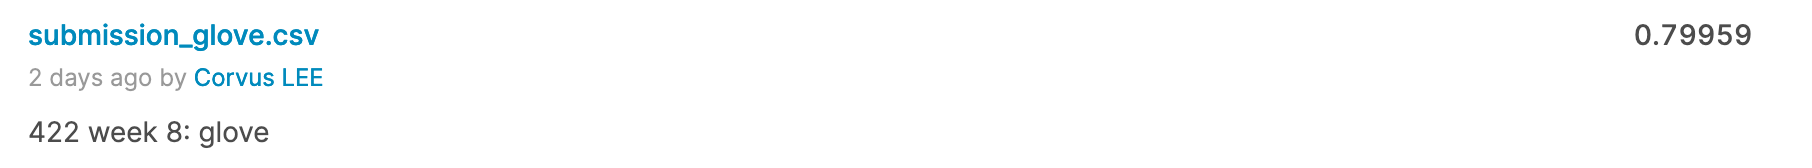

## GloVe.Twitter.200d

In [32]:
# List of pretrained word vectors
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [33]:
# Download the pretrained word vector
# chakin.download(number=20)

### Text processing

In [34]:
# Tokenize
tokenizer = Tokenizer()  # Default split as the pretrained word vector has http but not http://

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print('Number of unique tokens:', len(word_index))

Number of unique tokens: 19416


In [35]:
# Top 30 frequent tokens
list(word_index)[:30]

['t',
 'co',
 'http',
 'the',
 'a',
 'in',
 'to',
 'of',
 'i',
 'and',
 'is',
 'for',
 'on',
 'you',
 'my',
 'it',
 'that',
 'with',
 'at',
 'by',
 'this',
 'https',
 'are',
 'have',
 'from',
 'be',
 'was',
 'me',
 'like',
 'as']

In [36]:
# Padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)

X_train_seq = pad_sequences(X_train_seq, padding='post', truncating='post', maxlen=40) 
X_valid_seq = pad_sequences(X_valid_seq, padding='post', truncating='post', maxlen=40)

print(X_train_seq.shape, X_valid_seq.shape)

(5988, 40) (1497, 40)


In [37]:
# How does the sequence (and padding) look like?
print(X_train[:1])
print(X_train_seq[:1])

['Arsonists being blamed for a blaze at a plastics recycling business in Adelaide | @pcaldicott7 reports. #7NewsAdl http://t.co/r1Xwdnvb0g']
[[5869  148 2392   12    5  655   19    5 5870 3003  691    6 5871 5872
   901 5873    3    1    2 5874    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [38]:
# Indexing word vectors
embeddings_index = {}

with open('glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        
print('Number of texts:', len(embeddings_index))

Number of texts: 1193514


In [39]:
# How does the word 'twitter' look like in the embedding layer
embeddings_index['twitter']

array([ 1.0433e-01,  3.9882e-01, -6.9542e-01, -5.0984e-01,  6.6959e-02,
       -6.6277e-01,  2.5302e-01, -6.1320e-01,  6.6954e-02,  3.4897e-01,
       -3.4739e-01, -4.3558e-01,  3.0712e-01, -4.9802e-01, -9.2228e-01,
       -4.3034e-01,  8.4605e-02, -2.7696e-01,  3.6586e-01, -5.0237e-01,
        1.4885e-02,  2.1380e-01, -2.1657e-01, -6.2373e-02, -4.4156e-01,
       -1.6118e+00,  2.9537e-01, -1.0533e+00, -1.0280e+00,  9.4658e-01,
       -2.4770e-01,  1.2826e-01,  1.6348e-01, -4.6791e-01,  6.4240e-01,
       -1.6270e-01,  5.0066e-01, -1.4123e-01, -3.0530e-01, -2.2070e-01,
       -4.9756e-01,  4.8674e-01, -1.9606e-01,  4.7974e-01,  2.0614e-01,
       -6.0490e-02, -2.7333e-01, -2.8277e-01, -2.5695e-01,  1.5094e-01,
        5.7955e-01, -5.3770e-01,  1.7460e-02, -3.0005e-01, -8.4298e-02,
        3.6802e-01, -1.0117e+00,  2.3048e-01, -5.8210e-02, -2.3774e-01,
        6.5609e-03, -2.8949e-01, -2.7410e-01,  2.0116e-01, -1.4284e-01,
        2.1115e-01,  8.4995e-02,  3.3736e-01,  2.8317e-01,  3.37

In [40]:
# Embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(19417, 200)

### Modeling

In [41]:
reset_keras()

# Build the model
model = keras.Sequential([
    keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim,
                           embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                           input_length=40,
                           trainable=False),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           3883400   
_________________________________________________________________
gru (GRU)                    (None, 40, 128)           126720    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,109,321
Trainable params: 225,921
Non-trainable params: 3,883,400
_________________________________________________________________


In [42]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [43]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/glove.twitter.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/disaster_tweets/logs/run_2020_05_31-02_36_12


In [44]:
%%time

# Fit the model
history = model.fit(
    x=X_train_seq,
    y=y_train,
    epochs=100,
    validation_data=(X_valid_seq, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb],
    shuffle=True
    )

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 6s 1ms/sample - loss: 0.6817 - accuracy: 0.5725 - val_loss: 0.6542 - val_accuracy: 0.5932
Epoch 2/100
5988/5988 [==============================] - 4s 706us/sample - loss: 0.5475 - accuracy: 0.7244 - val_loss: 0.4439 - val_accuracy: 0.8103
Epoch 3/100
5988/5988 [==============================] - 4s 732us/sample - loss: 0.4297 - accuracy: 0.8101 - val_loss: 0.4379 - val_accuracy: 0.8123
Epoch 4/100
5988/5988 [==============================] - 1s 237us/sample - loss: 0.4127 - accuracy: 0.8236 - val_loss: 0.4395 - val_accuracy: 0.8143
Epoch 5/100
5988/5988 [==============================] - 4s 698us/sample - loss: 0.4049 - accuracy: 0.8225 - val_loss: 0.4286 - val_accuracy: 0.8156
Epoch 6/100
5988/5988 [==============================] - 4s 701us/sample - loss: 0.3972 - accuracy: 0.8288 - val_loss: 0.4249 - val_accuracy: 0.8150
Epoch 7/100
5988/5988 [==============================] - 1s 

### Evaluate

In [45]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/glove.twitter.h5')

In [46]:
# Performance on the validation set
y_pred = model.predict_classes(X_valid_seq)

print(classification_report(y_valid, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.80121   0.90847   0.85147       874
           1    0.84190   0.68379   0.75465       623

    accuracy                        0.81496      1497
   macro avg    0.82155   0.79613   0.80306      1497
weighted avg    0.81814   0.81496   0.81118      1497



In [47]:
# AUC score
roc_auc_score(y_valid, y_pred)

0.7961274706061686

### Predict

In [48]:
# Preprocess the test data
X_test_seq = tokenizer.texts_to_sequences(df_test_raw['text'].values)
X_test_seq = pad_sequences(X_test_seq, padding='post', truncating='post', maxlen=40) 

# Predict the classes
y_test = model.predict_classes(X_test_seq)

# Prepare file for submission
submission = pd.DataFrame({'id': df_test_raw['id'].values,
                           'target': y_test[:,0]})
submission.to_csv('submission_glove_twitter.csv', index=False)

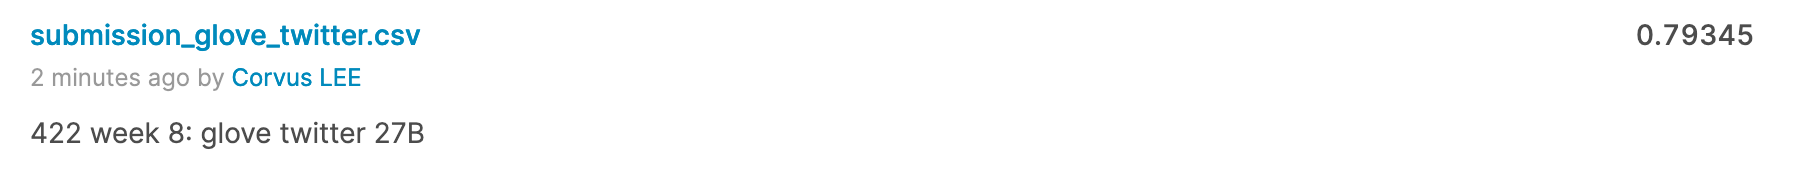

# Summary

<hr>

| Experiment | Description | f1 (valid) | f1 (test) | auc (valid) |
| --- | --- | --- | --- | --- |
| 1 | nnlm-en-dim50 | .78688 | .76380 | .78311 |
| 2 | glove (6B wiki) | .78977 | .79959 | .78341 |
| 3 | glove (27B twitter) | .80306 | .79345 | .79613 |

We can make use of a similar approach to business problems like identifying critical messages from customer reviews, calls and complaint logs. This can be framed as a binary classification problem with NLP. Without knowing the relevant costs (e.g., dissatisfied customer vs. case handling), we should find a model with a good precision/recall balance, i.e., high AUC score.

With the two methods that we have examined, custom-build a RNN utilizing a pretrained word vectors (specialized for specific context, in this example, Twitter messages) has the best performance. By tuning the classification threshold, we can have a model optimized for the situation (e.g., highest recall with a certain level of precision).

The TensorFlow Hub also provides other sentence encoder, some for specialized purpose such as question & answer, semantic similarity, multilingual, etc., which we may use for fast prototyping.

<hr>